In [ ]:

!pip install ultralytics


!pip install roboflow

!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 902.2/902.2 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 45.1 MB/s eta 0:00:00


In [ ]:

import os
import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from scipy.stats import mannwhitneyu
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from ultralytics import YOLO
from roboflow import Roboflow
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import hashlib
from google.colab import files
from IPython.display import Image
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
from sklearn.decomposition import NMF
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from keras.preprocessing import image
from sklearn.decomposition import PCA
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
def count_dataset_record(tf_dataset):


    record_count = tf_dataset.reduce(0, lambda x, _: x + 1).numpy()

    return record_count

In [ ]:

feature_description = {
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/filename': tf.io.FixedLenFeature([], tf.string),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
}

In [ ]:

def cv_mre(data, n_components):


  nmf = NMF(n_components=n_components, random_state=42)
  W = nmf.fit_transform(data)
  H = nmf.components_

  kf = KFold(n_splits=10, shuffle=True, random_state=42)
  errors = []

  for train_index, test_index in kf.split(data):
      train_data, test_data = data[train_index], data[test_index]
      nmf = NMF(n_components=n_components, random_state=42)
      W_train = nmf.fit_transform(train_data)
      H = nmf.components_
      W_test = nmf.transform(test_data)
      reconstruction = np.dot(W_test, H)
      error = mean_squared_error(test_data, reconstruction)
      errors.append(error)

  mean_error = np.mean(errors)
  print(f'Cross-validated mean reconstruction error when n_components = {n_components}: {mean_error}')

In [ ]:

def parse_example(example_proto):

    example = tf.io.parse_single_example(example_proto, feature_description)


    image = tf.image.decode_jpeg(example['image/encoded'])


    image_format = example['image/format']
    width = example['image/width']
    height = example['image/height']
    filename = example['image/filename']

    class_text = tf.sparse.to_dense(example['image/object/class/text'], default_value='')

    xmin = tf.sparse.to_dense(example['image/object/bbox/xmin'], default_value=0.0)
    xmax = tf.sparse.to_dense(example['image/object/bbox/xmax'], default_value=0.0)
    ymin = tf.sparse.to_dense(example['image/object/bbox/ymin'], default_value=0.0)
    ymax = tf.sparse.to_dense(example['image/object/bbox/ymax'], default_value=0.0)


    bbox = tf.stack([xmin, ymin, xmax, ymax], axis=-1)

    return image, image_format, width, height, filename, class_text, bbox

In [ ]:

def extract_features2(parsed_dataset):
    images, image_formats, widths, heights, filenames, class_texts, bboxes, mean_intensities = [], [], [], [], [], [], [], []

    for example in parsed_dataset:

        image, image_format, width, height, filename, class_text, bbox = example


        images.append(image.numpy())
        image_formats.append(image_format.numpy().decode('utf-8'))
        widths.append(width.numpy())
        heights.append(height.numpy())
        filenames.append(filename.numpy().decode('utf-8'))
        class_texts.append([c.numpy().decode('utf-8') for c in class_text])
        bboxes.append(bbox.numpy())


        mean_intensity = np.mean(image.numpy())
        mean_intensities.append(mean_intensity)

    return images, image_formats, widths, heights, filenames, class_texts, bboxes, mean_intensities

In [ ]:

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = base_model.predict(img_data)
    return features.flatten()

In [ ]:

def read_label_map(label_map_path):
    label_map = {}
    with open(label_map_path, 'r') as f:
        lines = f.readlines()

    id = None

    for line in lines:
        line = line.strip()
        if line.startswith("id:"):

            id_str = line.split(":")[1].strip().rstrip(',')
            id = int(id_str)
        elif line.startswith("name:"):
            if id is not None:
                name = line.split(":")[1].strip().strip("'")
                label_map[id] = name
                id = None
    return label_map

In [ ]:

def count_files_in_directory(directory):

    files = os.listdir(directory)

    file_count = len(files)
    return file_count

In [ ]:

def generate_short_identifier(image_file):
    hash_object = hashlib.md5(image_file.encode())


    return hash_object.hexdigest()[:8]

In [ ]:
def calculate_fuzzy_metrics(features, max_clusters=10, m=2.0, error=0.005, maxiter=1000, seed=42):
    fpcs = []
    pes = []
    xb_indices = []

    for n_clusters in range(2, max_clusters + 1):
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            features.T, n_clusters, m, error=error, maxiter=maxiter, seed=seed
        )


        fpcs.append(fpc)


        pe = -np.sum(u * np.log(u)) / features.shape[1]
        pes.append(pe)


        N = features.shape[1]
        cluster_distances = np.linalg.norm(features[:, :, np.newaxis] - cntr.T[np.newaxis, :, :], axis=1)
        min_dist = np.min(cluster_distances[cluster_distances != 0])
        xb_index = np.sum((u**2).T * (cluster_distances**2)) / (N * min_dist**2)
        xb_indices.append(xb_index)

    return fpcs, pes, xb_indices

In [ ]:

def plot_component_images(component_index, num_images=5):
    component_weights = W[:, component_index]


    top_indices = component_weights.argsort()[-num_images:][::-1]

    plt.figure(figsize=(12, 6))
    for i, index in enumerate(top_indices):
        img = image.load_img(all_image_paths[index], target_size=(224, 224))
        img_array = image.img_to_array(img)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_array.astype('uint8'))
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(f"Top {num_images} Images for Component {component_index}", y=0.3)

In [ ]:

def load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    return image.img_to_array(img) / 255.0


def display_cluster_images(cluster_indices, image_paths, num_images=5):
    for cluster_id in np.unique(cluster_indices):
        plt.figure(figsize=(12, 6))
        cluster_images = np.where(cluster_indices == cluster_id)[0]
        selected_images = np.random.choice(cluster_images, num_images, replace=False)
        for i, img_idx in enumerate(selected_images):
            img = load_image(image_paths[img_idx])
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.suptitle(f'Top 5 Images for Cluster {cluster_id}', y=0.3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

url = 'https://universe.roboflow.com/ds/HQMHsQu4n4?key=B236ZDZWEo'

response = requests.get(url)

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="vO200m2VEA65CSakchvR")
project = rf.workspace("plant-disease-detection-89qrx").project("plant-disease-detection-znzrh")
version = project.version(8)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to plant-disease-detection-8 in yolov8:: 100%|██████████| 58036/58036 [00:09<00:00, 6233.19it/s]


In [ ]:

compressed_file = '/content/compressed_file.zip'


with open(compressed_file, 'wb') as f:
    f.write(response.content)

print("Downloaded content has been successfully written to a file.")
print("-----------------------------------------------------------\n")


!unzip compressed_file.zip

print("Compressed file has been successfully unzipped.")
print("-----------------------------------------------------------")

Streaming output truncated to the last 5000 lines.
  inflating: train/labels/shape-30-_jpg.rf.2d87157369b4ac36dc72dd2555750d8b.txt  
  inflating: train/labels/shape-30-_jpg.rf.40c2ff4120596cfb39981ee87412ffc7.txt  
  inflating: train/labels/shape-30-_jpg.rf.45f89698cdc17f258c80f38d3e9f0d94.txt  
  inflating: train/labels/shape-30-_jpg.rf.4abb91d211d6057cef5ef266f27c35a1.txt  
  inflating: train/labels/shape-30-_jpg.rf.5968c517394305aad8bbbb2afcd89cfc.txt  
  inflating: train/labels/shape-30-_jpg.rf.5b18c0e380c7d77bae477c0ce846e156.txt  
  inflating: train/labels/shape-30-_jpg.rf.6b010526f8828958a6f448d0a207f121.txt  
  inflating: train/labels/shape-30-_jpg.rf.9af0b41fe92c09940589666fa2c7cb10.txt  
  inflating: train/labels/shape-30-_jpg.rf.b69925311e2a2961d367d123545c6572.txt  
  inflating: train/labels/shape-30-_jpg.rf.c569f7792b898fd7f38caf6b304afb30.txt  
  inflating: train/labels/shape-30-_jpg.rf.e9c9ce0405b3d02536a01d8e7c99ac10.txt  
  inflating: train/labels/shape-300-_jpg.rf.107

In [ ]:

train_tfrecord = '/content/drive/MyDrive/train2.tfrecord'
test_tfrecord = '/content/drive/MyDrive/test2.tfrecord'


raw_train_dataset = tf.data.TFRecordDataset(train_tfrecord)
raw_test_dataset = tf.data.TFRecordDataset(test_tfrecord)


parsed_train_dataset = raw_train_dataset.map(parse_example)
parsed_test_dataset = raw_test_dataset.map(parse_example)

print("TFRecords datasets for training and test data have been successfully created and parsed.")
print("--------------------------------------------------------------------------")

TFRecords datasets for training and test data have been successfully created and parsed.
--------------------------------------------------------------------------


In [ ]:
num_train_records = count_dataset_record(raw_train_dataset)
num_test_records = count_dataset_record(raw_test_dataset)

print('Number of records in the training dataset:', num_train_records)
print('Number of records in the test dataset:',num_test_records)
print('-------------------------------------------------')
total_records = num_train_records + num_test_records
print('Total records:',total_records)

train_percent = (num_train_records/total_records) * 100
test_percent = (num_test_records/total_records) * 100

print(f'\nThe split is {train_percent:.0f}% training and {test_percent:.0f}% test.')

Number of records in the training dataset: 26011
Number of records in the test dataset: 1000
-------------------------------------------------
Total records: 27011

The split is 96% training and 4% test.


In [ ]:

train_images, train_image_formats, train_widths, train_heights, train_filenames, train_class_texts, train_bboxes, train_mean_intensities = extract_features2(parsed_train_dataset)

test_images, test_image_formats, test_widths, test_heights, test_filenames, test_class_texts, test_bboxes, test_mean_intensities = extract_features2(parsed_test_dataset)

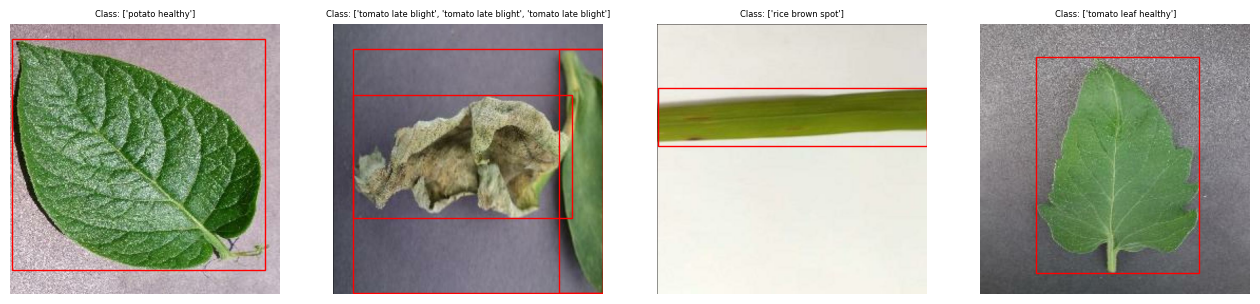

In [ ]:

num_example = 4

fig, ax = plt.subplots(1, num_example, figsize=(16, 4))

for i in range(num_example):
    title = f'Class: {train_class_texts[i][0:num_example-1]}'

    ax[i].imshow(train_images[i])
    ax[i].axis('off')
    ax[i].set_title(title, fontsize=6)


    for bbox in train_bboxes[i]:
        xmin, ymin, xmax, ymax = bbox
        rect = patches.Rectangle((xmin * train_widths[i], ymin * train_heights[i]), (xmax - xmin) * train_widths[i], (ymax - ymin) * train_heights[i], linewidth=1, edgecolor='r', facecolor='none')
        ax[i].add_patch(rect)

plt.show()

In [ ]:
from collections import Counter


flattened_classes = [item for sublist in train_class_texts for item in sublist]


class_counts = Counter(flattened_classes)


unique_classes = set(flattened_classes)

print(f'There are {len(unique_classes)} unique classes.\n')


for cls, count in class_counts.items():
    print(f'{cls}: {count}')


There are 41 unique classes.

potato healthy: 279
tomato late blight: 734
rice brown spot: 671
tomato leaf healthy: 657
healthy cassava: 1006
northern leaf blight: 679
peach healthy: 649
grape leaf blight: 667
cedar apple rust: 508
mosaic  cassava: 5592
peach bacterial spot: 645
grape healthy: 675
corn healthy: 668
cassava Brown Streak Disease: 1932
potato early blight: 649
bell pepper healthy: 655
apple scab: 650
cherry powdery mildew: 640
tomato early blight: 673
grape black rot: 651
potato late blight: 659
cassava bacterial blight: 1021
tomato septoria leaf spot: 653
bell pepper bacterial spot: 656
corn cerespora leaf spot: 652
strawberry leaf scorch: 734
tomato leaf mould: 651
corn common rust: 665
grape esca: 650
rice healthy: 622
tomato bacterial spot: 659
cherry healthy: 649
apple healthy: 654
rice hispa: 619
rice leaf blast: 649
cassava green mottle: 2077
strawberry healthy: 655
orange citrus greening: 653
apple black rot: 655
squash powdery mildew: 733
spider mites two-spotted

Number of healthy samples: 7529
Number of diseased samples: 18482


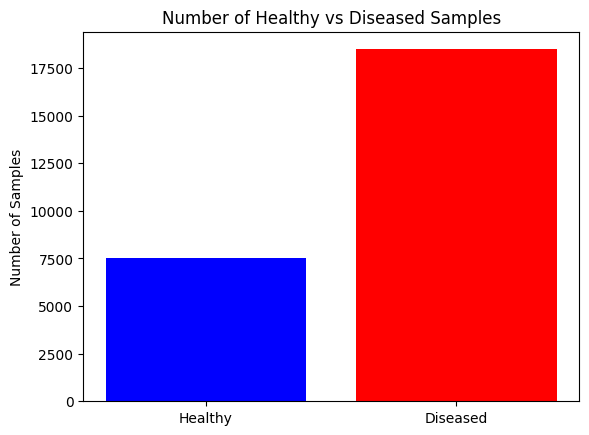

In [ ]:

plant_issues = ["blight", "rust", "spot", "mite", "rot", "bacteria", "mildew", "virus", "scab", "spider", "squash", "powdery","Streak","mottle","esca","mosaic","citrus","hispa","blast","scorch","mould"]


healthy_intensities = []
diseased_intensities = []


for i, class_texts in enumerate(train_class_texts):
    is_diseased = False


    for class_text in class_texts:
        for issue in plant_issues:
            if issue in class_text.lower():
                is_diseased = True
                break
        if is_diseased:
            break


    if is_diseased:
        diseased_intensities.append(train_mean_intensities[i])
    else:
        healthy_intensities.append(train_mean_intensities[i])

num_healthy_samples = len(healthy_intensities)
num_diseased_samples = len(diseased_intensities)
print('Number of healthy samples:', num_healthy_samples)
print('Number of diseased samples:', num_diseased_samples)

labels = ['Healthy', 'Diseased']
sample_counts = [num_healthy_samples, num_diseased_samples]

fig, ax = plt.subplots()
bars = ax.bar(labels, sample_counts, color=['blue', 'red'])

ax.set_ylabel('Number of Samples')
ax.set_title('Number of Healthy vs Diseased Samples')
plt.show()

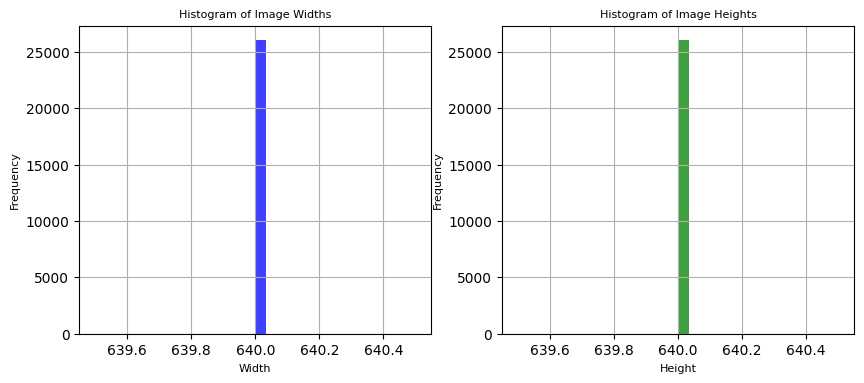

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))


ax[0].hist(train_widths, bins=30, alpha=0.75, color='b')
ax[0].set_xlabel('Width', fontsize=8)
ax[0].set_ylabel('Frequency', fontsize=8)
ax[0].set_title('Histogram of Image Widths', fontsize=8)
ax[0].grid(True)


ax[1].hist(train_heights, bins=30, alpha=0.75, color='g')
ax[1].set_xlabel('Height', fontsize=8)
ax[1].set_ylabel('Frequency', fontsize=8)
ax[1].set_title('Histogram of Image Heights', fontsize=8)
ax[1].grid(True)

In [ ]:
train_image_formats[0:5]

['jpg', 'jpg', 'jpg', 'jpg', 'jpg']

In [ ]:
import yaml

# Load the YAML file
yaml_file_path = '/content/plant-disease-detection-8/data.yaml'  # Replace with your YAML file path
pbtxt_file_path = 'label_map.pbtxt'  # Output file name

with open(yaml_file_path, 'r') as yaml_file:
    data = yaml.safe_load(yaml_file)

# Convert the names into the pbtxt format
with open(pbtxt_file_path, 'w') as pbtxt_file:
    for i, name in enumerate(data['names'], start=1):
        pbtxt_file.write(f"item {{\n")
        pbtxt_file.write(f"  id: {i}\n")
        pbtxt_file.write(f"  name: '{name}'\n")
        pbtxt_file.write(f"}}\n")

print(f"Label map saved to {pbtxt_file_path}")


Label map saved to label_map.pbtxt


In [ ]:
label_map_path = '/content/label_map.pbtxt'
label_map = read_label_map(label_map_path)


expected_num_classes = 41
actual_num_classes = len(label_map)

if actual_num_classes < expected_num_classes:
    print(f"Warning: Only {actual_num_classes} classes loaded from {label_map_path}. Expected {expected_num_classes}.")
elif actual_num_classes > expected_num_classes:
    print(f"Warning: Loaded {actual_num_classes} classes from {label_map_path}. Expected {expected_num_classes}.")
else:
    print(f"Successfully loaded {actual_num_classes} classes from {label_map_path}.")


for id, name in label_map.items():
    print(f'ID: {id} | Name: {name}')

Successfully loaded 41 classes from /content/label_map.pbtxt.
ID: 1 | Name: apple black rot
ID: 2 | Name: apple healthy
ID: 3 | Name: apple scab
ID: 4 | Name: bell pepper bacterial spot
ID: 5 | Name: bell pepper healthy
ID: 6 | Name: cassava Brown Streak Disease
ID: 7 | Name: cassava bacterial blight
ID: 8 | Name: cassava green mottle
ID: 9 | Name: cedar apple rust
ID: 10 | Name: cherry healthy
ID: 11 | Name: cherry powdery mildew
ID: 12 | Name: corn cerespora leaf spot
ID: 13 | Name: corn common rust
ID: 14 | Name: corn healthy
ID: 15 | Name: grape black rot
ID: 16 | Name: grape esca
ID: 17 | Name: grape healthy
ID: 18 | Name: grape leaf blight
ID: 19 | Name: healthy cassava
ID: 20 | Name: mosaic  cassava
ID: 21 | Name: northern leaf blight
ID: 22 | Name: orange citrus greening
ID: 23 | Name: peach bacterial spot
ID: 24 | Name: peach healthy
ID: 25 | Name: potato early blight
ID: 26 | Name: potato healthy
ID: 27 | Name: potato late blight
ID: 28 | Name: rice brown spot
ID: 29 | Name: 

In [ ]:
class_map = {
    "apple black rot": 1,
    "apple healthy": 2,
    "apple scab": 3,
    "bell pepper bacterial spot": 4,
    "bell pepper healthy": 5,
    "cassava Brown Streak Disease": 6,
    "cassava bacterial blight": 7,
    "cassava green mottle": 8,
    "cedar apple rust": 9,
    "cherry healthy": 10,
    "cherry powdery mildew": 11,
    "corn cerespora leaf spot": 12,
    "corn common rust": 13,
    "corn healthy": 14,
    "grape black rot": 15,
    "grape esca": 16,
    "grape healthy": 17,
    "grape leaf blight": 18,
    "healthy cassava": 19,
    "mosaic  cassava": 20,
    "northern leaf blight": 21,
    "orange citrus greening": 22,
    "peach bacterial spot": 23,
    "peach healthy": 24,
    "potato early blight": 25,
    "potato healthy": 26,
    "potato late blight": 27,
    "rice brown spot": 28,
    "rice healthy": 29,
    "rice hispa": 30,
    "rice leaf blast": 31,
    "spider mites two-spotted spider mite": 32,
    "squash powdery mildew": 33,
    "strawberry healthy": 34,
    "strawberry leaf scorch": 35,
    "tomato bacterial spot": 36,
    "tomato early blight": 37,
    "tomato late blight": 38,
    "tomato leaf healthy": 39,
    "tomato leaf mould": 40,
    "tomato septoria leaf spot": 41,
}


In [ ]:
stat, p_value = mannwhitneyu(healthy_intensities, diseased_intensities, alternative='two-sided')

print('Statistic:', stat)
print('P-value:', p_value)

Statistic: 85267010.5
P-value: 1.5401680775170189e-179


In [ ]:

alpha = 0.05

if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference in mean pixel intensity between diseased and healthy plants.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference in mean pixel intensity between diseased and healthy plants.')

Reject the null hypothesis: There is a significant difference in mean pixel intensity between diseased and healthy plants.


In [ ]:
yaml_content = """
train: /content/train/images  # Directory containing training images
val: /content/test/images  # Directory containing validation images
test: /content/test/images  # Directory containing test images
nc: 41  # Number of classes

names:
  - "apple black rot"
  - "apple healthy"
  - "apple scab"
  - "bell pepper bacterial spot"
  - "bell pepper healthy"
  - "cassava Brown Streak Disease"
  - "cassava bacterial blight"
  - "cassava green mottle"
  - "cedar apple rust"
  - "cherry healthy"
  - "cherry powdery mildew"
  - "corn cerespora leaf spot"
  - "corn common rust"
  - "corn healthy"
  - "grape black rot"
  - "grape esca"
  - "grape healthy"
  - "grape leaf blight"
  - "healthy cassava"
  - "mosaic  cassava"
  - "northern leaf blight"
  - "orange citrus greening"
  - "peach bacterial spot"
  - "peach healthy"
  - "potato early blight"
  - "potato healthy"
  - "potato late blight"
  - "rice brown spot"
  - "rice healthy"
  - "rice hispa"
  - "rice leaf blast"
  - "spider mites two-spotted spider mite"
  - "squash powdery mildew"
  - "strawberry healthy"
  - "strawberry leaf scorch"
  - "tomato bacterial spot"
  - "tomato early blight"
  - "tomato late blight"
  - "tomato leaf healthy"
  - "tomato leaf mould"
  - "tomato septoria leaf spot"
"""

# Save the content to a YAML file
with open('/content/data.yaml', 'w') as f:
    f.write(yaml_content)


In [ ]:

images_dir = '/content/plant-disease-detection-8/train/images'
labels_dir = '/content/plant-disease-detection-8/train/labels'


image_files = os.listdir(images_dir)

In [ ]:
print('Count of images:', count_files_in_directory(images_dir))
print('Count of labels:', count_files_in_directory(labels_dir))

Count of images: 26011
Count of labels: 26011


In [ ]:

base_model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:

all_image_paths = '/content/plant-disease-detection-8/train/images'
all_image_paths = [os.path.join(all_image_paths, fname) for fname in os.listdir(all_image_paths) if fname.endswith('.jpg')]


all_features = np.array([extract_features(img_path) for img_path in all_image_paths])

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Maximum number of iterations 200 reached. Increase it to improve convergence.


Text(0.5, 1.0, 'Elbow Curve to Select the Optimal Number of Components')

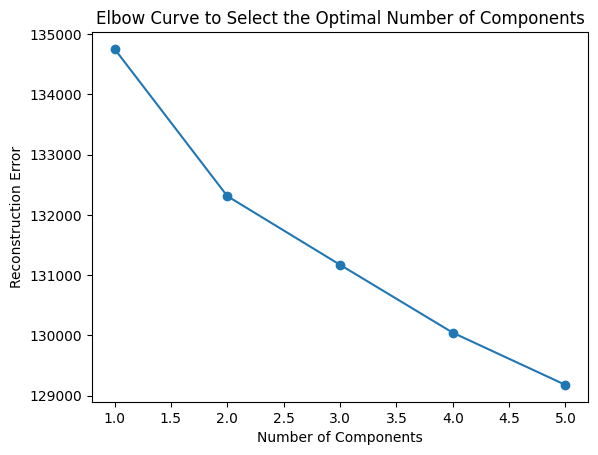

In [ ]:
n_components_range = range(1, 6)

reconstruction_errors = []

for n in n_components_range:
    nmf = NMF(n_components=n, random_state=42)
    W = nmf.fit_transform(all_features)
    H = nmf.components_


    reconstruction_error = nmf.reconstruction_err_
    reconstruction_errors.append(reconstruction_error)

plt.plot(n_components_range, reconstruction_errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Elbow Curve to Select the Optimal Number of Components')


In [ ]:
cv_mre(all_features, 3)
cv_mre(all_features, 4)

Cross-validated mean reconstruction error when n_components = 3: 26.738408279418945
Cross-validated mean reconstruction error when n_components = 4: 26.293347930908205


In [ ]:

n_components = 4


nmf = NMF(n_components=n_components, random_state=42)


W = nmf.fit_transform(all_features)


H = nmf.components_

In [ ]:
for i, component in enumerate(H):
    print(f"Component {i}:")
    print(component)

Component 0:
[          0           0           0 ...           0     0.31405           0]
Component 1:
[    0.52252     0.29158      1.1305 ...       0.242      1.6216     0.88533]
Component 2:
[   0.043733           0     0.23518 ...   0.0022305     0.19064           0]
Component 3:
[   0.078057     0.44155    0.092255 ...     0.04217      3.5937           0]


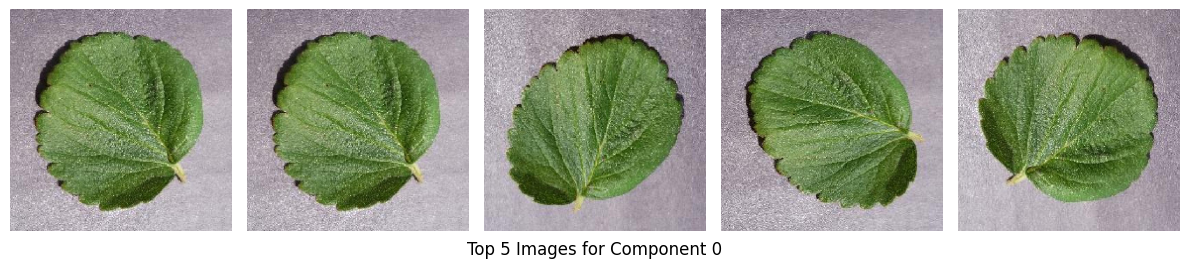

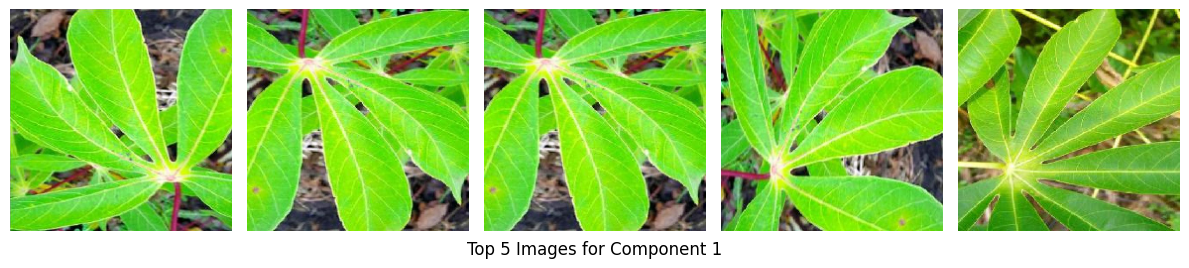

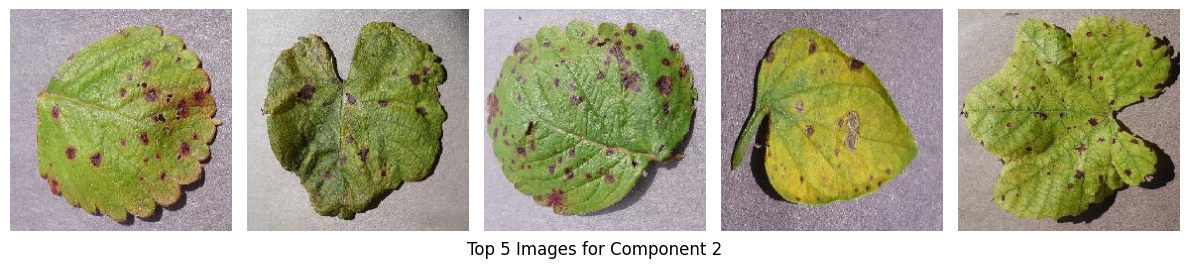

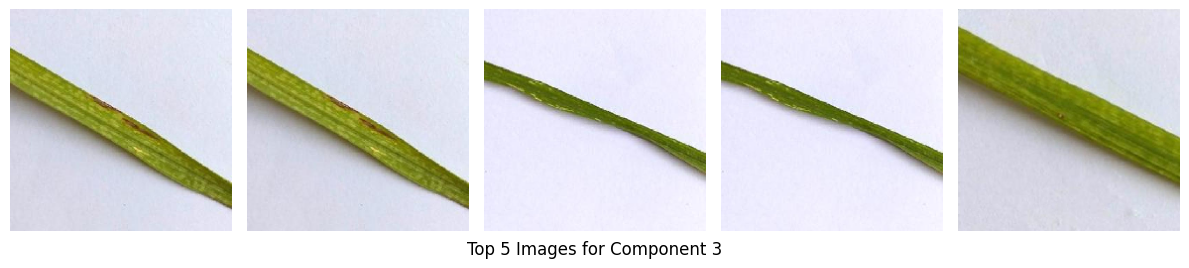

In [ ]:
# Plot images for each component.
for i in range(n_components):
    plot_component_images(i)

In [ ]:
n_clusters = 3

# Set a random seed for reproducibility.
random_seed = 42

# Initialize Fuzzy C-Means with Euclidean distance.

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    all_features.T,  # Transpose to match expected input shape.
    c=n_clusters,  # Number of clusters.
    m=1.5,  # Fuzziness parameter.
    error=0.005,  # Convergence criterion.
    maxiter=1000,  # Maximum number of iterations.
    seed=random_seed
)

In [ ]:
cluster_centers = cntr
membership_values = u


In [ ]:
cluster_assignments = np.argmax(membership_values, axis=0)

In [ ]:
seq = iaa.Sequential([

    # Adjust contrast of the image randomly between 0.5 and 1.5 times the original contrast.
    iaa.ContrastNormalization((0.5, 1.5)),

    # Adjust brightness by multiplying pixel values by a factor between 0.8 and 1.2.
    iaa.Multiply((0.8, 1.2)),

    # Flip the image horizontally with a 50% chance.
    iaa.Fliplr(0.5),

    # Randomly crop the image with the crop percentage varying between 0% and 10%.
    iaa.Crop(percent=(0, 0.1)),

    # Rotate the image randomly between -10 and 10 degrees.
    iaa.Affine(rotate=(-10, 10)),

])

Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.


In [ ]:
for image_file in image_files:
    image_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))

    # Read the image, convert it to RGB as imgaug works with RGB images.
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read the bounding boxes from label file.
    bbs = []
    exclude_image = False  # Flag to determine whether to exclude the image

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_label = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            if class_label in {11, 15, 27}:
                exclude_image = True  # Set flag to True if label is in the exclude list
                break  # Stop processing this image if any label is to be excluded

            # Convert to absolute coordinates as required by Yolo.
            x1 = int((x_center - width/2) * image.shape[1])
            y1 = int((y_center - height/2) * image.shape[0])
            x2 = int((x_center + width/2) * image.shape[1])
            y2 = int((y_center + height/2) * image.shape[0])

            bbs.append(BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2, label=class_label))

    if exclude_image:
        # Delete the image and label file
        if os.path.exists(image_path):
            os.remove(image_path)
        if os.path.exists(label_path):
            os.remove(label_path)
        print(f"Deleted image and label due to labels: {image_file}")
        continue  # Skip the rest of the loop if this image is excluded

    # Create BoundingBoxesOnImage object with bounding boxes and shape of image.
    bbs = BoundingBoxesOnImage(bbs, shape=image.shape)

    # Augment image and bounding boxes.
    augmented_image, augmented_bbs = seq(image=image, bounding_boxes=bbs)

    # Convert augmented image back to BGR.
    augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)

    # Save augmented image.
    short_identifier = generate_short_identifier(image_file)
    augmented_image_name = f"augmented_{short_identifier}.jpg"
    augmented_image_path = os.path.join(images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, augmented_image)
    print(f"Saved augmented image: {augmented_image_path}")

    # Update labels file with augmented bounding boxes.
    augmented_label_name = f"{short_identifier}_augmented.txt"
    augmented_label_path = os.path.join(labels_dir, augmented_label_name)
    with open(augmented_label_path, 'w') as f:
        for bb in augmented_bbs.bounding_boxes:
            # Convert bounding box coordinates back to relative values.
            center_x = (bb.x1 + bb.x2) / 2 / image.shape[1]
            center_y = (bb.y1 + bb.y2) / 2 / image.shape[0]
            width = (bb.x2 - bb.x1) / image.shape[1]
            height = (bb.y2 - bb.y1) / image.shape[0]
            f.write(f"{bb.label} {center_x} {center_y} {width} {height}\n")
    print(f"Updated labels file: {augmented_label_path}")


Streaming output truncated to the last 5000 lines.
Deleted image and label due to labels: shape-16-_jpg.rf.e7edc83c29e4add763fe81882923ebd6.jpg
Saved augmented image: /content/plant-disease-detection-8/train/images/augmented_e570fdab.jpg
Updated labels file: /content/plant-disease-detection-8/train/labels/e570fdab_augmented.txt
Saved augmented image: /content/plant-disease-detection-8/train/images/augmented_4f6386eb.jpg
Updated labels file: /content/plant-disease-detection-8/train/labels/4f6386eb_augmented.txt
Saved augmented image: /content/plant-disease-detection-8/train/images/augmented_45740687.jpg
Updated labels file: /content/plant-disease-detection-8/train/labels/45740687_augmented.txt
Saved augmented image: /content/plant-disease-detection-8/train/images/augmented_26652e70.jpg
Updated labels file: /content/plant-disease-detection-8/train/labels/26652e70_augmented.txt
Saved augmented image: /content/plant-disease-detection-8/train/images/augmented_fd679ceb.jpg
Updated labels fil

In [ ]:
print('Count of images are augmentation:', count_files_in_directory(images_dir))
print('Count of labels are augmentation:', count_files_in_directory(labels_dir))

Count of images are augmentation: 48100
Count of labels are augmentation: 48100


In [ ]:
model = YOLO('yolov8m.yaml')

In [ ]:
!yolo task=detect mode=train model=yolov8m.yaml data=/content/plant-disease-detection-8/data.yaml epochs=30 imgsz=320 batch=8


Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/plant-disease-detection-8/data.yaml, epochs=30, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

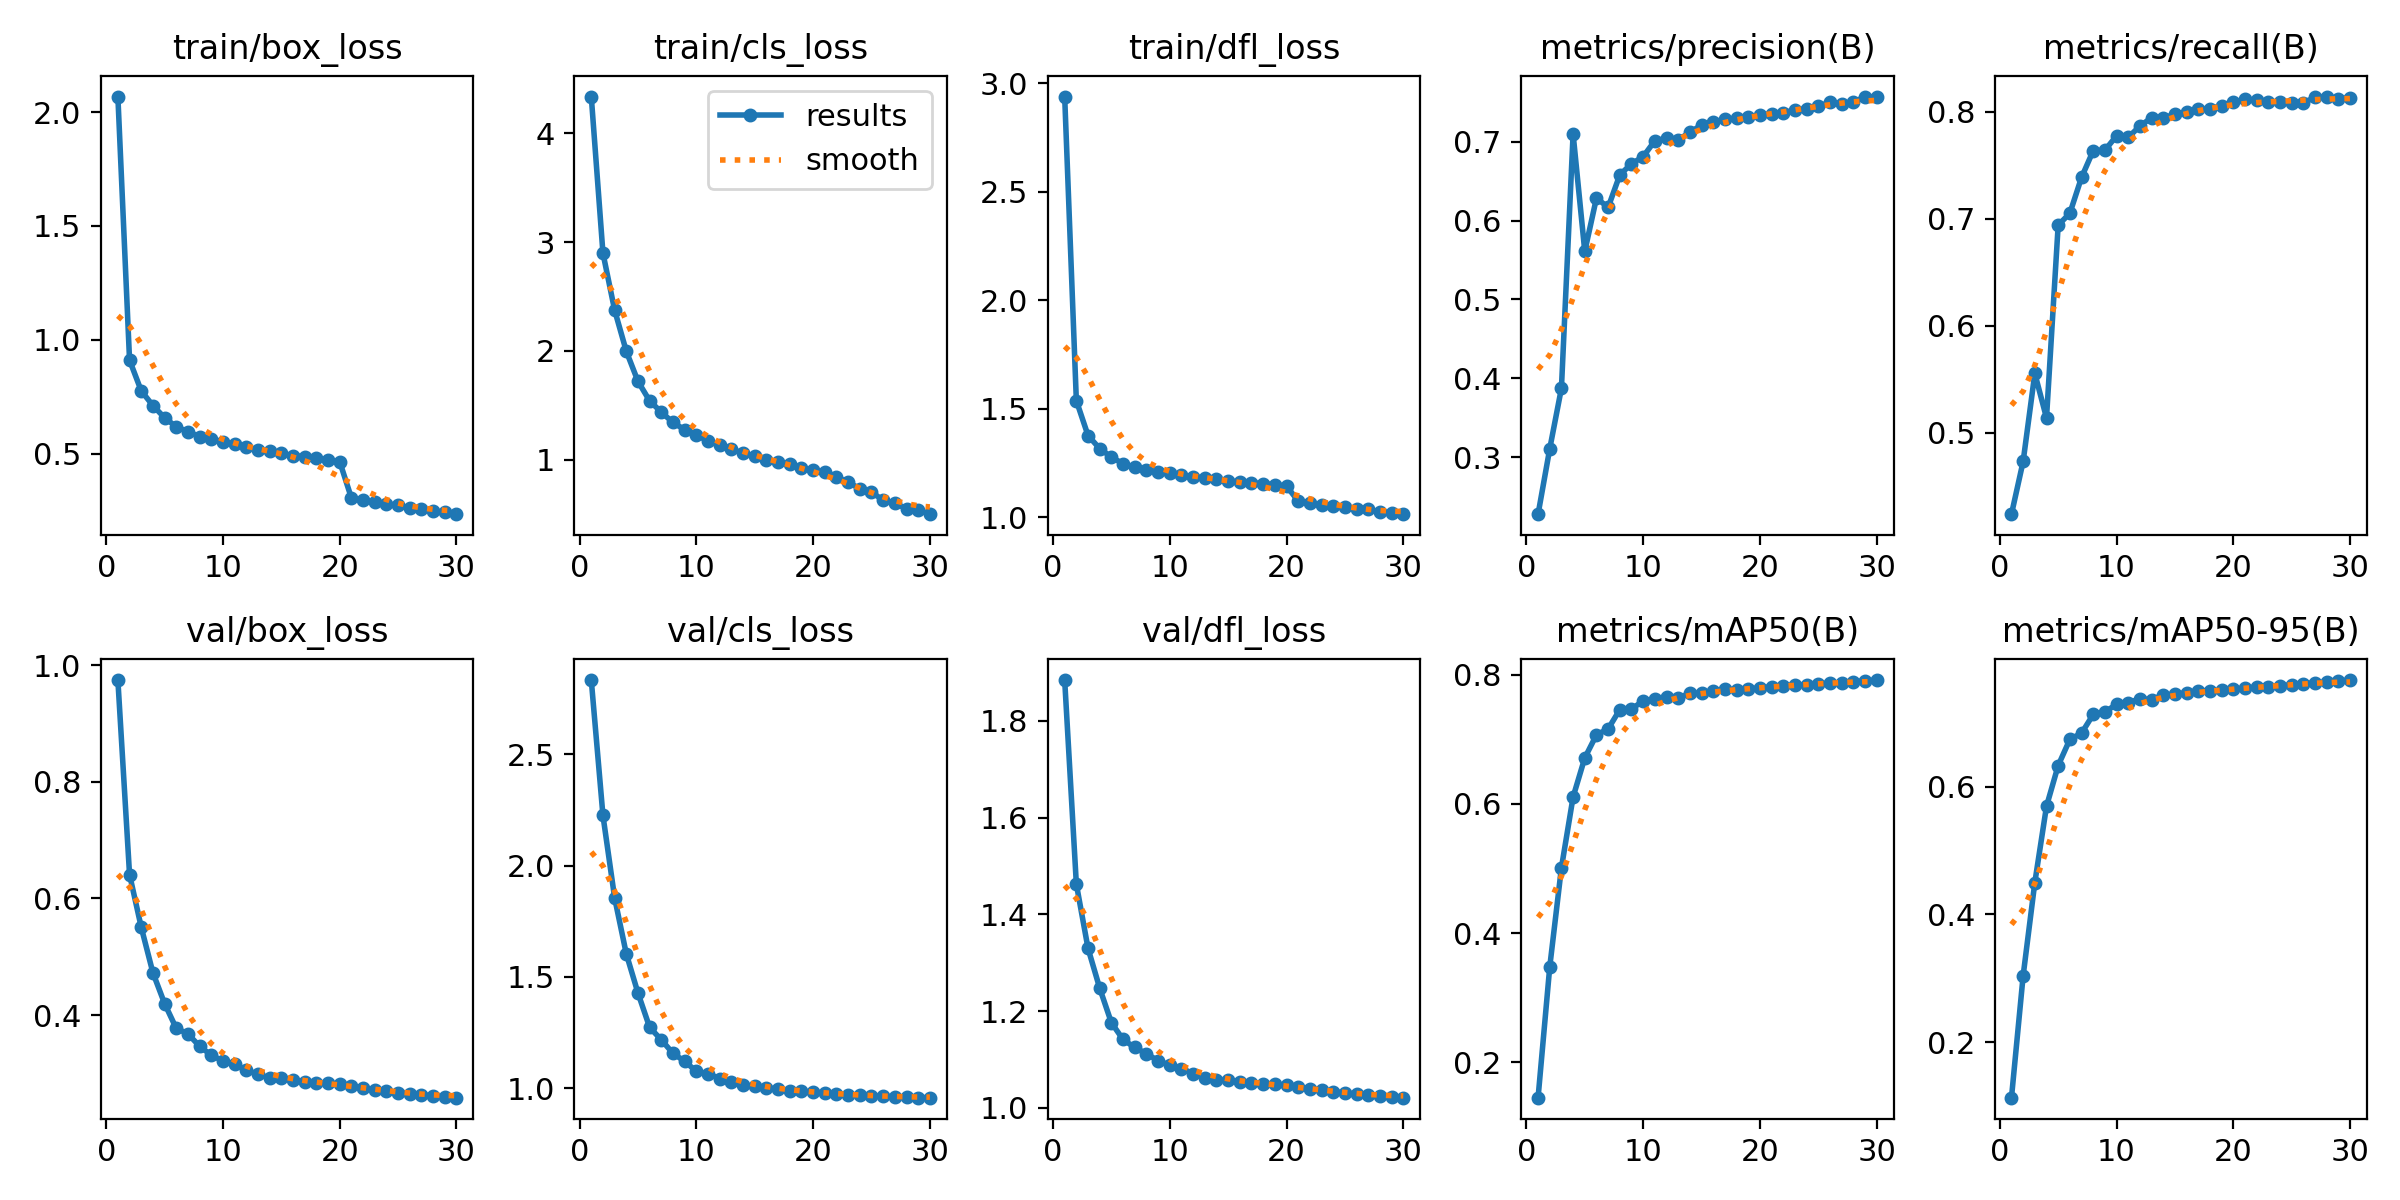

In [ ]:
Image(filename=f'/content/runs/detect/train/results.png')

In [ ]:
model = YOLO("/content/runs/detect/train/weights/best.pt")

In [ ]:
source_path = "/content/runs/detect/train/PR_curve.png"  # Replace this with your actual file path
destination_folder = "/content/drive/My Drive"  # Replace with your desired Google Drive folder

# Ensure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# Copy the file to Google Drive
destination_path = os.path.join(destination_folder, os.path.basename(source_path))
!cp "$source_path" "$destination_path"

print(f"File saved to {destination_path}")

File saved to /content/drive/My Drive/PR_curve.png


In [ ]:
import shutil
import os
import shutil  # Import shutil for file and folder operations


In [ ]:
source_path = "/content/runs/detect/train"  # Replace with the path to your folder or file in Colab
destination_folder = "/content/drive/My Drive"  # Replace with your desired folder in Google Drive

# Ensure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# Copy the folder or file to Google Drive
if os.path.isdir(source_path):
    # If it's a folder, copy it
    shutil.copytree(source_path, os.path.join(destination_folder, os.path.basename(source_path)))
else:
    # If it's a file, copy it
    shutil.copy2(source_path, destination_folder)

print(f"Content copied to {destination_folder}")

Content copied to /content/drive/My Drive


In [ ]:
from ultralytics import YOLO

# Load the trained YOLO model
model = YOLO("/content/runs/detect/train/weights/best.pt")

# Perform inference on an image
results = model("/content/plant-disease-detection-8/test/images/007f0b62-a0f0-4c4a-9b1b-119616dd87c2___UMD_Powd-M-0279_JPG.rf.ec69765a7a61bcf24c7ce113fae55c3e.jpg", save=True, conf=0.25)  # Adjust `conf` for confidence threshold

# Display the results
results.show()  # Display the image with predictions (Colab compatible)



image 1/1 /content/plant-disease-detection-8/test/images/007f0b62-a0f0-4c4a-9b1b-119616dd87c2___UMD_Powd-M-0279_JPG.rf.ec69765a7a61bcf24c7ce113fae55c3e.jpg: 320x320 1 squash powdery mildew, 11.4ms
Speed: 5.2ms preprocess, 11.4ms inference, 556.5ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict


AttributeError: 'list' object has no attribute 'show'